<a href="https://colab.research.google.com/github/Ch-rode/CoNLL/blob/main/CONLL2003_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#data analysis packages
import pandas as pd
import numpy as np

In [3]:
#data preparation
df= pd.read_csv('gdrive/My Drive/LICEO-UNIVERSITA/TESI MAGISTRALE/BERT/train_BERT.txt', sep=" ", encoding="latin1")
df.columns = ['Word','POS','POS2','Tag']
df.drop('POS2',axis=1,inplace=True)
NaN=np.nan
df['Sentence #']= NaN
df[['Sentence #']]=df[["Sentence #"]].astype(object)
#Let us take a sneak-peak into the dataset first
df.head()


,Word,POS,Tag,Sentence #
0,EU,NNP,B-ORG,NaN
1,rejects,VBZ,O,NaN
2,German,JJ,B-MISC,NaN
3,call,NN,O,NaN
4,to,TO,O,NaN


In [4]:
c = list()
for i in range(len(df)):
  #print(df['Word'][i])
  if df['Word'][i]=='.':
    c.append('Sentence:')
  else:
    c.append(NaN)

In [5]:
## I remove the last element and add an element at the top of the list so it scans all of one position (this is because I need Sentence: 1 to be at the first word of the sentence and not where there is a period)
c.pop()
c.insert(0,'Sentence:')

In [6]:
sen = 'Sentence:'
count = 1
for i in range(len(c)):
  if c[i]=='Sentence:':
    c[i] = sen+str(count)
    count+=1

In [7]:
#c

In [8]:
df['Sentence #']=c

In [9]:
df

,Word,POS,Tag,Sentence #
0,EU,NNP,B-ORG,Sentence:1
1,rejects,VBZ,O,NaN
2,German,JJ,B-MISC,NaN
3,call,NN,O,NaN
4,to,TO,O,NaN
...,...,...,...,...
251226,younger,JJR,O,NaN
251227,brother,NN,O,NaN
251228,",",",",O,NaN
251229,Bobby,NNP,B-PER,NaN


https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/

In [10]:
pip install transformers==2.6.0

In [11]:
from tqdm import tqdm, trange

In [12]:
data=df #final dataframe 

In [13]:
data.tail(10)

,Word,POS,Tag,Sentence #
251221,Cup,NNP,I-MISC,NaN
251222,winning,JJ,O,NaN
251223,team,NN,O,NaN
251224,with,IN,O,NaN
251225,his,PRP$,O,NaN
251226,younger,JJR,O,NaN
251227,brother,NN,O,NaN
251228,",",",",O,NaN
251229,Bobby,NNP,B-PER,NaN
251230,.,.,O,NaN


In [14]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [15]:
getter = SentenceGetter(data)
#getter

In [16]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0] #sentence number 0 word number 0

['EU']

In [17]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0]) #label of the word 0

['B-ORG']


In [18]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}


In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.8.0+cu101'

Here we fix some configurations. We will limit our sequence length to 75 tokens and we will use a batch size of 32 as suggested by the Bert paper. Note, that Bert supports sequences of up to 512 tokens.

In [20]:
MAX_LEN = 75
bs = 32

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [22]:
#torch.cuda.get_device_name(0)

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [24]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [25]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]


In [26]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [27]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [28]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [29]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [30]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2020, test_size=0.2) #controllare di aver messo la stessa perc nei vari modelli
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.2)


In [31]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [32]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [33]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'2.6.0'

In [34]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


In [35]:
model.cuda();
#https://datascience.stackexchange.com/questions/54907/model-cuda-in-pytorch

In [36]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=0.001,
    eps=0.01
)


In [37]:
from transformers import get_linear_schedule_with_warmup

epochs = 5
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=1,
    num_training_steps=total_steps
)


In [38]:
pip install seqeval

In [39]:
from seqeval.metrics import f1_score, accuracy_score

In [40]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #  print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Average train loss: 0.8691063200102912


Epoch:  20%|██        | 1/5 [01:08<04:34, 68.72s/it]

Validation loss: 0.4449645602389386
Validation Accuracy: 0.8843273231622746

Average train loss: 0.36505924560957487


Epoch:  40%|████      | 2/5 [02:17<03:26, 68.70s/it]

Validation loss: 0.37921660592812195
Validation Accuracy: 0.912621359223301

Average train loss: 0.2977079184932841


Epoch:  60%|██████    | 3/5 [03:25<02:17, 68.58s/it]

Validation loss: 0.34083443139924813
Validation Accuracy: 0.9167822468793343

Average train loss: 0.2415442832145426


Epoch:  80%|████████  | 4/5 [04:33<01:08, 68.45s/it]

Validation loss: 0.30527884486180384
Validation Accuracy: 0.9276005547850208

Average train loss: 0.20942675999055307


Epoch: 100%|██████████| 5/5 [05:41<00:00, 68.40s/it]

Validation loss: 0.3110804981919692
Validation Accuracy: 0.9312066574202497



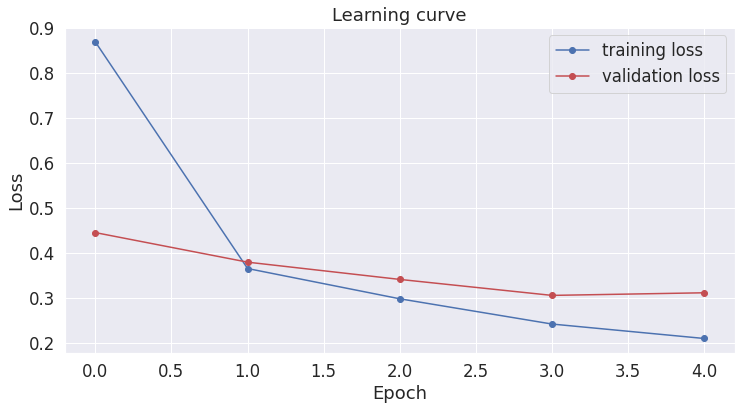

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [52]:
#Apply the model to a new sentence
test_sentence = "David Bowie was a singer"

In [53]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [54]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [55]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)


In [56]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

B-PER	[CLS]
B-PER	David
B-PER	Bowie
O	was
O	a
B-PER	singer
O	[SEP]
